In [138]:
import numpy as np
import torch
from torch import nn, tensor, Tensor
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

## Data

Generate a dataset with a few cycles of sine

In [23]:
x = torch.arange(0, 4 * torch.pi, torch.pi / 64)

In [24]:
y = torch.sin(x)

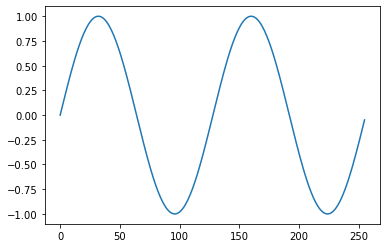

In [25]:
plt.plot(y)
plt.show()

Build training / inference data

In [41]:
def build_sample(x: float, interval: float = torch.pi/64, window_size: int = 32) -> dict:
    end = x + interval * (window_size * 2 + 1)
    y = torch.sin(torch.arange(x, end, interval))
    return {
        'src': y[:window_size],
        'tgt': y[window_size-1:window_size*2-1],
        'y': y[window_size:window_size*2],
    }

In [42]:
build_sample(0, window_size=4)

{'src': tensor([0.0000, 0.0491, 0.0980, 0.1467]),
 'tgt': tensor([0.1467, 0.1951, 0.2430, 0.2903]),
 'y': tensor([0.1951, 0.2430, 0.2903, 0.3369])}

In [238]:
dataset_size = 1028
x = []
y = []
for i in range(dataset_size):
    s = build_sample(i / dataset_size * 2 * torch.pi, interval=torch.pi/64, window_size=32)
    x.append({ k: v for k, v in s.items() if k in ['src', 'tgt'] })
    #x.append((s['src'], s['tgt']))
    y.append(s['y'])

In [239]:
class Dataset():
    def __init__(self, x, y): self.x, self.y = x, y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i]

In [240]:
ds = Dataset(x, y)

In [241]:
from torch.utils.data import DataLoader
batch_size = 8
train_dl = DataLoader(ds, batch_size, shuffle=True, drop_last=True)
valid_dl = DataLoader(ds, batch_size, shuffle=False)

## Training

In [143]:
def get_device(): return torch.device('cpu')

In [144]:
class Trainer:
    def __init__(self, model, train_dataloader, valid_dataloader, lr=0.00001):
        self.model = model
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        self.lr = lr
        self.optimizer = AdamW(model.parameters(), lr=lr)
        #self.optimizer = SGD(model.parameters(), lr=lr)
        self.device = get_device()
        self.loss_fn = nn.MSELoss()

    def train(self, num_epochs, max_batches=None):
        num_train_batches = min(len(self.train_dataloader), max_batches or float('inf'))
        num_valid_batches = min(len(self.valid_dataloader), max_batches or float('inf'))
        num_train_steps = num_epochs * num_train_batches
        num_valid_steps = num_epochs * num_valid_batches
        self.lr_scheduler = self.__get_scheduler(num_train_steps)
        
        outputs = []
        losses = []
        
        self.train_progress = tqdm(range(num_train_steps))
        self.train_progress.set_description('Training')
        self.valid_progress = tqdm(range(num_valid_steps))
        self.valid_progress.set_description('Validation')
        for epoch in range(num_epochs):
            epoch_losses = self.__train(max_batches)
            epoch_outputs = self.__eval(max_batches)
            outputs.extend(epoch_outputs)
            losses.append(np.mean(epoch_losses))
        
        return {
            'outputs': outputs,
            'losses': losses,
        }

    def __train(self, max_batches=None):
        losses = []
        model.train()
        for i, batch in enumerate(self.train_dataloader):
            if max_batches and i >= max_batches: break
            x, y = batch
            outputs = self.model(**x)
            loss = self.loss_fn(outputs, y)
            losses.append(loss.item())
            loss.backward()

            self.optimizer.step()
            self.lr_scheduler.step()
            self.train_progress.update(1)
        return losses

    def __eval(self, max_batches=None):
        all_outputs = []
        
        model.eval()
        for i, batch in enumerate(self.valid_dataloader):
            if max_batches and i >= max_batches: break
            #batch = {k: v.to(self.device) for k, v in batch.items()}
            with torch.no_grad():
                x, y = batch
                outputs = self.model(**x)[:, -1]

            # Record outputs
            all_outputs.append(outputs.tolist())
                        
            self.valid_progress.update(1)
        return all_outputs

    def __get_scheduler(self, num_training_steps):
        return OneCycleLR(self.optimizer, self.lr, total_steps=num_training_steps, steps_per_epoch=1)

In [244]:
model = nn.Transformer(d_model=32)

In [254]:
trainer = Trainer(model, train_dl, valid_dl)
results = trainer.train(30)

  0%|          | 0/3840 [00:00<?, ?it/s]

  0%|          | 0/3870 [00:00<?, ?it/s]

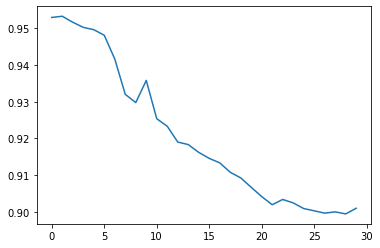

In [255]:
plt.plot(results['losses'])
plt.show()

In [256]:
all_outputs = sum(results['outputs'], [])

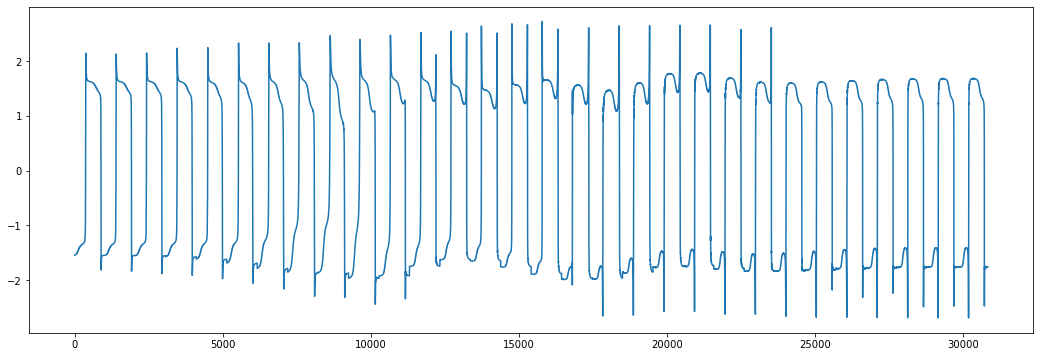

In [257]:
plt.figure(figsize=(18, 6))
plt.plot(all_outputs)
plt.show()

## Inference

In [258]:
# Start the model off with zeros
# Shift left and feed the resulting value
# Repeat

In [259]:
src = torch.zeros(32).unsqueeze(0)
tgt = torch.zeros(32).unsqueeze(0)

In [260]:
outputs = []
for _ in range(512):
    out = model(src, tgt)[:, -1].item()
    src = torch.cat([src[:, 1:], tgt[:, -1].unsqueeze(dim=1)], dim=1)
    tgt = torch.cat([tgt[:, 1:], torch.tensor([[out]])], dim=1)
    outputs.append(out)

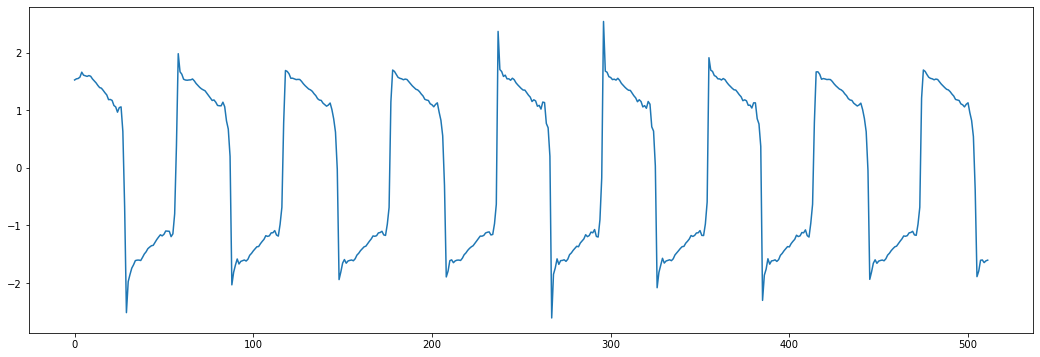

In [261]:
plt.figure(figsize=(18, 6))
plt.plot(outputs)
plt.show()

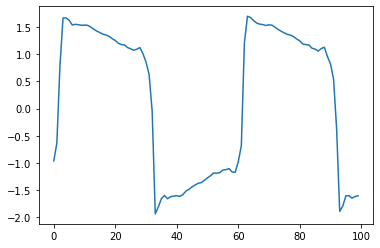

In [262]:
plt.plot(outputs[-100:])
plt.show()